# Reward-Modulated Hebbian Learning

This notebook demonstrates reward-modulated Hebbian learning in PLSN.
We train a simple network using reward signals to shape weight updates.

The reward signal is computed from output similarity to input (lower MSE = higher reward).
Positive rewards strengthen recent activity patterns, while negative rewards weaken them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from plsn import NetworkBuilder
from plsn.core.learning import HebbianConfig
from plsn.init import FullyConnectedInitializer, WeightInitializer
from plsn.init.distributions import UniformWeightDistribution

## Create a Simple Network

We create a minimal network:
- 4 input neurons
- 4 model neurons (fully connected to themselves)
- 4 output neurons

The goal is to learn the identity mapping: output should match input.

We use small initial weights and a moderate learning rate with weight decay for stability.

In [2]:
network = (
    NetworkBuilder()
    .with_dimensions(2)
    .with_bands(1)  # Single band for simplicity
    .with_input_initializer(
        neurons=4,
        connections=[
            FullyConnectedInitializer(),
            WeightInitializer(UniformWeightDistribution(0.1, 0.3)),
        ]
    )
    .with_model_initializer(
        neurons=4,
        connections=[
            FullyConnectedInitializer(),
            WeightInitializer(UniformWeightDistribution(0.1, 0.3)),
        ]
    )
    .with_output_initializer(
        neurons=4,
        connections=[
            FullyConnectedInitializer(),
            WeightInitializer(UniformWeightDistribution(0.1, 0.3)),
        ]
    )
    .with_learning(
        config=HebbianConfig(
            learning_rate=0.001,
            band_learning_rate=0.001,
            bcm_tau=50.0,
            theta_init=0.2,
            weight_decay=0.0001,
            min_weight=0.0,
            max_weight=5.0,
        )
    )
    .with_seed(42)
    .build()
)

# Enable learning
network.learning_enabled = True

print(network)
print(f"Inputs: {network.num_inputs}, Outputs: {network.num_outputs}")

LatticeNetwork(neurons=12, dims=2, bands=1, connections=44)
Inputs: 4, Outputs: 4


## Define Loss and Reward Functions

We use mean squared error (MSE) to measure how well output matches input.
The reward is the negative loss (higher is better).

In [3]:
def mse_loss(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean squared error between true and predicted values."""
    return float(np.mean((y_true - y_pred) ** 2))


def compute_reward(inputs: np.ndarray, outputs: np.ndarray) -> float:
    """Compute reward based on similarity between input and output.
    
    Returns positive reward when output matches input well,
    negative reward when they differ significantly.
    """
    loss = mse_loss(inputs, outputs)
    # Convert loss to reward: low loss = high reward
    # Using exponential decay: reward approaches 1 as loss approaches 0
    reward = np.exp(-loss * 5) - 0.5  # Range roughly [-0.5, 0.5]
    return float(reward)

## Training Loop

For each iteration:
1. Generate random input pattern in [0, 1]
2. Run forward pass
3. Compute reward based on output vs input similarity
4. Apply reward-modulated learning

In [4]:
rng = np.random.default_rng(123)
num_epochs = 10000
num_steps = 3  # Forward steps per input pattern

losses = []
rewards = []

for epoch in range(num_epochs):
    # Generate random input pattern
    inputs = rng.uniform(0.2, 0.8, size=network.num_inputs).astype(np.float32)
    network.set_input(inputs)
    
    # Run multiple forward steps to let signal propagate
    for _ in range(num_steps):
        outputs = network.forward()
    
    # Compute loss and reward
    loss = mse_loss(inputs, outputs)
    reward = compute_reward(inputs, outputs)
    
    # Apply learning with reward signal
    network.reward(reward)
    
    losses.append(loss)
    rewards.append(reward)
    
    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d}: loss={loss:.4f}, reward={reward:.4f}")

print(f"\nFinal mean loss (last 100): {np.mean(losses[-100:]):.4f}")

Epoch    0: loss=0.0212, reward=0.3996
Epoch  200: loss=0.1044, reward=0.0933
Epoch  400: loss=0.0718, reward=0.1985
Epoch  600: loss=0.0464, reward=0.2929
Epoch  800: loss=0.0291, reward=0.3648
Epoch 1000: loss=0.0118, reward=0.4427
Epoch 1200: loss=0.0219, reward=0.3965
Epoch 1400: loss=0.0265, reward=0.3761
Epoch 1600: loss=0.0244, reward=0.3852
Epoch 1800: loss=0.0271, reward=0.3732
Epoch 2000: loss=0.0205, reward=0.4024
Epoch 2200: loss=0.0391, reward=0.3224
Epoch 2400: loss=0.0487, reward=0.2839
Epoch 2600: loss=0.0705, reward=0.2028
Epoch 2800: loss=0.0430, reward=0.3064
Epoch 3000: loss=0.0755, reward=0.1855
Epoch 3200: loss=0.0422, reward=0.3096
Epoch 3400: loss=0.1094, reward=0.0786
Epoch 3600: loss=0.1059, reward=0.0888
Epoch 3800: loss=0.1342, reward=0.0113
Epoch 4000: loss=0.1626, reward=-0.0564
Epoch 4200: loss=0.1459, reward=-0.0180
Epoch 4400: loss=0.2156, reward=-0.1597
Epoch 4600: loss=0.1117, reward=0.0720
Epoch 4800: loss=0.1731, reward=-0.0792
Epoch 5000: loss=0.15

## Learning Curves

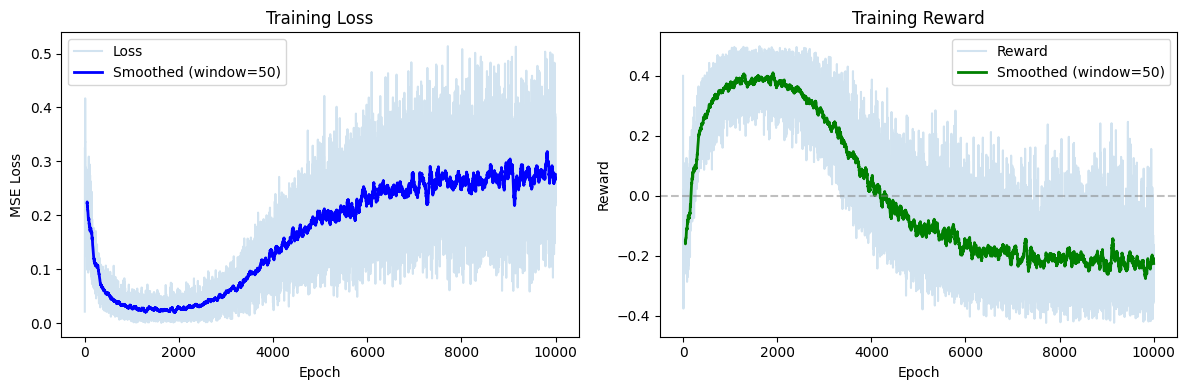

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Smoothed loss
window = 50
smoothed_loss = np.convolve(losses, np.ones(window)/window, mode='valid')
axes[0].plot(losses, alpha=0.2, label='Loss')
axes[0].plot(range(window-1, len(losses)), smoothed_loss, 'b-', linewidth=2, label=f'Smoothed (window={window})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

# Smoothed reward
smoothed_reward = np.convolve(rewards, np.ones(window)/window, mode='valid')
axes[1].plot(rewards, alpha=0.2, label='Reward')
axes[1].plot(range(window-1, len(rewards)), smoothed_reward, 'g-', linewidth=2, label=f'Smoothed (window={window})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reward')
axes[1].set_title('Training Reward')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

## Evaluate Trained Network

Test the network on new input patterns to see how well it replicates.

In [6]:
# Disable learning for evaluation
network.learning_enabled = False

test_inputs = [
    np.array([0.2, 0.4, 0.6, 0.8], dtype=np.float32),
    np.array([0.5, 0.5, 0.5, 0.5], dtype=np.float32),
    np.array([0.1, 0.9, 0.1, 0.9], dtype=np.float32),
    np.array([0.8, 0.6, 0.4, 0.2], dtype=np.float32),
]

print("Input → Output comparison:")
print("=" * 60)

for i, inputs in enumerate(test_inputs):
    network.set_input(inputs)
    for _ in range(num_steps):
        outputs = network.forward()
    
    loss = mse_loss(inputs, outputs)
    
    print(f"\nTest {i+1}:")
    print(f"  Input:  [{', '.join(f'{v:.2f}' for v in inputs)}]")
    print(f"  Output: [{', '.join(f'{v:.2f}' for v in outputs)}]")
    print(f"  MSE:    {loss:.4f}")

Input → Output comparison:

Test 1:
  Input:  [0.20, 0.40, 0.60, 0.80]
  Output: [0.01, 0.00, 0.00, 0.01]
  MSE:    0.2951

Test 2:
  Input:  [0.50, 0.50, 0.50, 0.50]
  Output: [0.01, 0.00, 0.00, 0.01]
  MSE:    0.2450

Test 3:
  Input:  [0.10, 0.90, 0.10, 0.90]
  Output: [0.01, 0.01, 0.01, 0.01]
  MSE:    0.4047

Test 4:
  Input:  [0.80, 0.60, 0.40, 0.20]
  Output: [0.01, 0.00, 0.00, 0.01]
  MSE:    0.2948


## Visualize Input vs Output

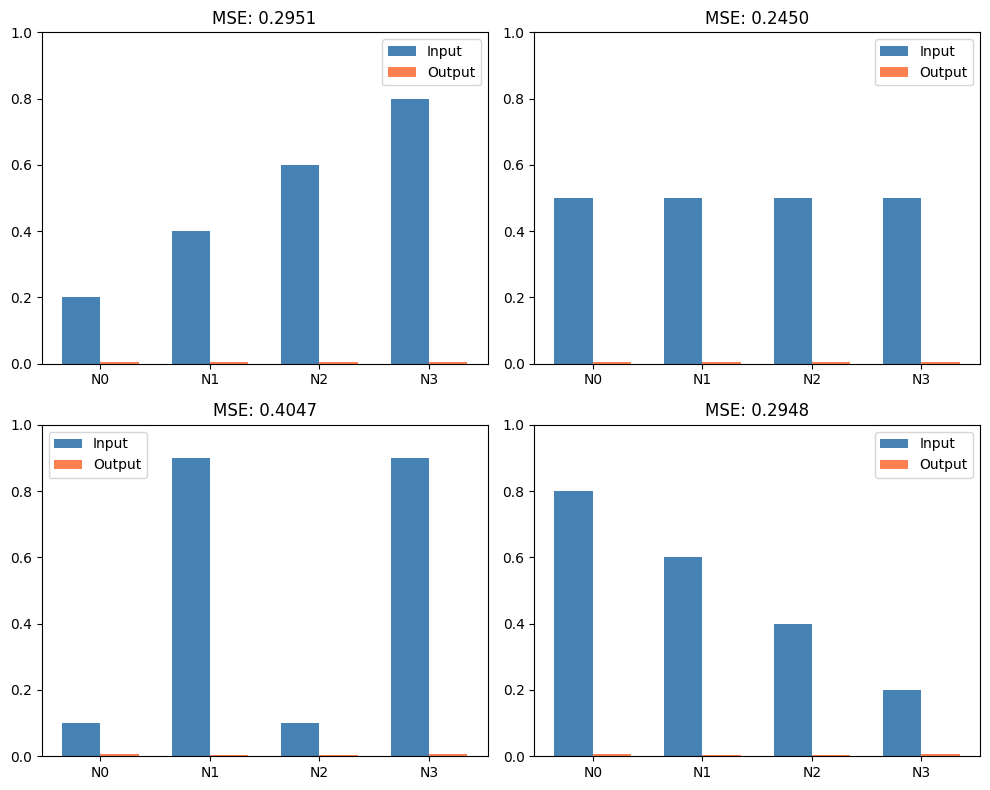

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, inputs in zip(axes.flat, test_inputs):
    network.set_input(inputs)
    for _ in range(num_steps):
        outputs = network.forward()
    
    x = np.arange(len(inputs))
    width = 0.35
    
    ax.bar(x - width/2, inputs, width, label='Input', color='steelblue')
    ax.bar(x + width/2, outputs, width, label='Output', color='coral')
    
    ax.set_xticks(x)
    ax.set_xticklabels([f'N{i}' for i in range(len(inputs))])
    ax.set_ylim(0, max(1.0, outputs.max() * 1.1))
    ax.legend()
    ax.set_title(f'MSE: {mse_loss(inputs, outputs):.4f}')

plt.tight_layout()
plt.show()